<a href="https://colab.research.google.com/github/DoraTheExploring/AFML/blob/master/AFML_AlgoPy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Get Data

In [ ]:
!wget https://raw.githubusercontent.com/chrisconlan/algorithmic-trading-with-python/1f615f488a3faa6274a701afccfcf977dfa83570/data/alternative_data/AWU.csv -O "awu_alt.csv"
!wget https://raw.githubusercontent.com/chrisconlan/algorithmic-trading-with-python/1f615f488a3faa6274a701afccfcf977dfa83570/data/eod/AWU.csv -O "awu_eod.csv"

--2021-04-25 14:55:24--  https://raw.githubusercontent.com/chrisconlan/algorithmic-trading-with-python/1f615f488a3faa6274a701afccfcf977dfa83570/data/alternative_data/AWU.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22773 (22K) [text/plain]
Saving to: ‘awu_alt.csv’

awu_alt.csv         100%[===================>]  22.24K  --.-KB/s    in 0.001s  

2021-04-25 14:55:24 (16.1 MB/s) - ‘awu_alt.csv’ saved [22773/22773]

--2021-04-25 14:55:24--  https://raw.githubusercontent.com/chrisconlan/algorithmic-trading-with-python/1f615f488a3faa6274a701afccfcf977dfa83570/data/eod/AWU.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent

In [ ]:
!ls -ls

total 144
 24 -rw-r--r-- 1 root root  22773 Apr 25 14:55 awu_alt.csv
116 -rw-r--r-- 1 root root 115288 Apr 25 14:55 awu_eod.csv
  4 drwxr-xr-x 1 root root   4096 Apr 21 13:39 sample_data


EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
awu_eod = pd.read_csv('awu_eod.csv')
awu_alt = pd.read_csv('awu_alt.csv')
awu_eod.index = pd.to_datetime(awu_eod.date)
awu_alt.index = pd.to_datetime(awu_alt.date)

In [ ]:
awu_eod.head()

,date,open,close,low,high,volume
date,,,,,,
2010-01-04,2010-01-04,193.94,191.70,190.63,195.51,968029
2010-01-05,2010-01-05,191.02,188.17,186.99,192.42,1427075
2010-01-06,2010-01-06,187.17,186.50,185.10,190.07,879014
2010-01-07,2010-01-07,185.03,185.19,183.63,186.64,1003719
2010-01-08,2010-01-08,184.67,187.02,182.78,187.27,804716


In [ ]:
awu_alt.head()

,date,value
date,,
2015-03-31,2015-03-31,23305.0
2015-04-01,2015-04-01,20640.0
2015-04-02,2015-04-02,23522.0
2015-04-06,2015-04-06,24449.0
2015-04-07,2015-04-07,21489.0


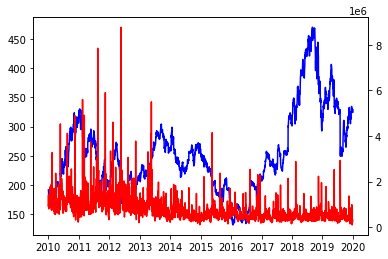

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(awu_eod.index, awu_eod.close, 'b-')
ax2.plot(awu_eod.index, awu_eod.volume, 'r-')

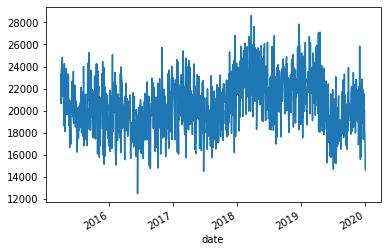

In [ ]:
awu_alt.value.plot()

In [ ]:
## The symmetric cusum filter
"""
Quality control method designed to detect a shift in the mean value of a measure quantity away from a target value.

"""

def getCusumEvents(raw, threshold):
  events, pos, neg = [], 0, 0
  diff = raw.diff()
  for ii in diff.index[1:]:
    pos, neg = max(0, pos+diff.loc[ii]), min(0, neg+diff.loc[ii])
    if neg < -threshold:
      neg=0; events.append(ii)
    elif pos> threshold:
      pos=0; events.append(ii)
  return(pd.DatetimeIndex(events))


def getCusumData(raw, threshold):
  data, pos, neg = [], 0, 0
  data.append([pos, neg])
  diff = raw.diff()
  for ii in diff.index[1:]:
    pos, neg = max(0, pos+diff.loc[ii]), min(0, neg+diff.loc[ii])
    if neg < -threshold:
      neg=0
    elif pos> threshold:
      pos=0; 
    data.append([pos, neg])
  return(pd.DataFrame(data, columns=['pos', 'neg']))


In [ ]:
threshold = 0.3
series = awu_alt.value
series_log = np.log(series)
events = getCusumEvents(series_log, threshold)
print(len(series))
print(len(events))
print(events[:5])

1198
147
DatetimeIndex(['2015-04-23', '2015-05-20', '2015-06-02', '2015-07-02',
               '2015-07-24'],
              dtype='datetime64[ns]', freq=None)


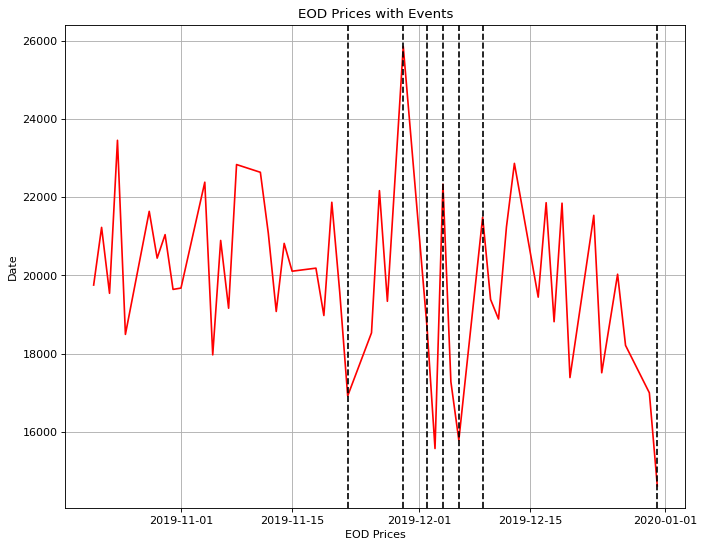

In [ ]:
series_sub = series[-50:]
events_sub = events[events.slice_indexer(series_sub.index.min())]

plt.figure(figsize=(10, 8), dpi=80)
plt.plot(series_sub, 'r-')
for dte in events_sub.to_pydatetime():
    plt.axvline(x=dte, color='k', linestyle='--')
plt.xlabel('EOD Prices')
plt.ylabel('Date')
plt.title('EOD Prices with Events')
plt.grid(True)
plt.show()

                 pos       neg
date                          
2015-03-31  0.000000  0.000000
2015-04-01  0.000000 -0.121437
2015-04-02  0.130705  0.000000
2015-04-06  0.169358  0.000000
2015-04-07  0.040310 -0.129048


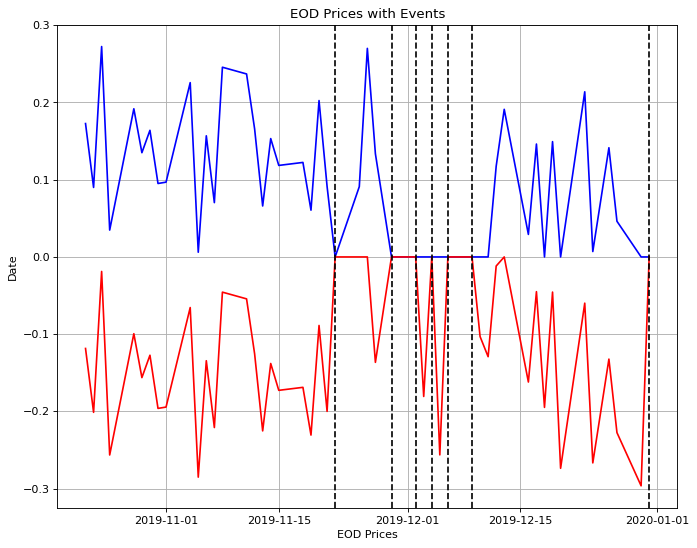

In [ ]:
cusumData = getCusumData(series_log, threshold)
cusumData.index=series_log.index
print(cusumData.head())

cusumData_sub = cusumData.loc[cusumData.index>series_sub.index.min()]

plt.figure(figsize=(10, 8), dpi=80)
plt.plot(cusumData_sub.pos, 'b-')
plt.plot(cusumData_sub.neg, 'r-')
for dte in events_sub.to_pydatetime():
    plt.axvline(x=dte, color='k', linestyle='--')
plt.xlabel('EOD Prices')
plt.ylabel('Date')
plt.title('EOD Prices with Events')
plt.grid(True)
plt.show()

In [ ]:
## Daily volatility estimates
"""
"""

def getDailyVol(close, span=100):
  df = close.index.searchsorted(close.index-pd.Timedelta(days=1))
  df = df[df>0]
  df = pd.Series(close.index[df-1], index=close.index[close.shape[0]-df.shape[0]:])
  df = close.loc[df.index]/ close.loc[df.values].values-1
  df = df.ewm(span=span).std()
  return df

In [ ]:
# Get events, labels, weights, and features
close_alt=awu_alt.value
close = awu_eod.close


dailyVol=getDailyVol(close_alt)

event_index = calculate_events(awu_alt.value, threshold=dailyVol.mean()*2)
event_labels, event_spans = calculate_labels(close, event_index, label_threshold=1, time_delta_days=1)

print(close.shape)
print(close_alt.shape)
print(event_index.shape)
print(event_labels.shape)
print(event_spans.shape)
print(event_labels.value_counts())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


(2516,)
(1198,)
(154,)
(154,)
(154,)
 0    88
 1    36
-1    30
dtype: int64


In [ ]:
revenue_series = awu_alt.value
price_series=awu_eod.close

weights = calculate_weights(event_spans, close.index)
features_df = calculate_features(price_series, revenue_series)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [ ]:
features_on_events = features_df.loc[event_index]

In [ ]:
# Convert labels and events to a data frame
labels_df = pd.DataFrame(event_labels)
labels_df.columns = ['y']

# Converts weights to a data frame
weights_df = pd.DataFrame(weights)
weights_df.columns = ['weights']

# Concatenate features to labels
df = pd.concat([features_on_events, weights_df, labels_df], axis=1)


In [ ]:
df.head()

,7_day_revenue_delta,7_day_return,7_day_vol,30_day_revenue_delta,30_day_return,30_day_vol,90_day_revenue_delta,90_day_return,90_day_vol,180_day_revenue_delta,180_day_return,180_day_vol,360_day_revenue_delta,360_day_return,360_day_vol,weights,y
2015-04-23,-0.058080,0.002107,0.072213,NaN,-0.032309,0.035793,NaN,-0.090532,0.027268,NaN,-0.071749,0.017489,NaN,-0.027617,0.012966,1.0,-1
2015-04-28,-0.032315,0.003338,0.039035,NaN,-0.013656,0.034050,NaN,-0.081720,0.026664,NaN,-0.093136,0.017419,NaN,-0.009025,0.012942,1.0,1
2015-05-20,-0.073328,-0.016397,0.098346,-0.072577,-0.042698,0.036327,NaN,-0.113203,0.025552,NaN,-0.200780,0.017325,NaN,-0.034035,0.012989,1.0,-1
2015-05-28,-0.071980,-0.029653,0.298965,-0.119059,-0.088636,0.072394,NaN,-0.151991,0.033094,NaN,-0.250718,0.020348,NaN,-0.109178,0.014027,1.0,0
2015-06-16,0.009877,0.000034,0.062764,-0.015939,-0.067033,0.073066,NaN,-0.150980,0.032253,NaN,-0.254999,0.020283,NaN,-0.105316,0.014014,1.0,0


In [ ]:
awu_eod = pd.read_csv('awu_eod.csv')
awu_alt = pd.read_csv('awu_alt.csv')
awu_eod.index = pd.to_datetime(awu_eod.date)
awu_alt.index = pd.to_datetime(awu_alt.date)

alt_series = awu_alt.value
price_series = awu_eod.close
time_delta_days=30
dailyVol=getDailyVol(alt_series)
cusum_threshold=dailyVol.mean()*2
label_threshold=1 # 1*20d vol

event_index = calculate_events(alt_series, threshold=cusum_threshold)
event_labels, event_spans = calculate_labels(close, event_index, label_threshold=label_threshold, time_delta_days=time_delta_days)

print("Price shape: ",alt_series.shape)
print("Events shape: ",event_index.shape)
print("Events Counts:")
print(event_labels.value_counts())

weights = calculate_weights(event_spans, close.index)
features_df = calculate_features(price_series, alt_series)

features_on_events = features_df.loc[event_index]

# Convert labels and events to a data frame
labels_df = pd.DataFrame(event_labels)
labels_df.columns = ['y']

# Converts weights to a data frame
weights_df = pd.DataFrame(weights)
weights_df.columns = ['weights']

# Concatenate features to labels
df = pd.concat([features_on_events, weights_df, labels_df], axis=1)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Price shape:  (1198,)
Events shape:  (154,)
Events Counts:
-1    68
 1    56
 0    25
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [ ]:
df.tail()

,7_day_revenue_delta,7_day_return,7_day_vol,30_day_revenue_delta,30_day_return,30_day_vol,90_day_revenue_delta,90_day_return,90_day_vol,180_day_revenue_delta,180_day_return,180_day_vol,360_day_revenue_delta,360_day_return,360_day_vol,weights,y
2019-12-03,-0.010401,-0.021838,0.113022,-0.056903,0.058620,0.050706,0.000268,0.205087,0.052031,0.017847,-0.042419,0.030333,-0.107352,-0.134744,0.020907,NaN,NaN
2019-12-04,0.004525,-0.026912,0.117401,-0.040623,0.051489,0.050415,0.017729,0.188861,0.052050,0.040819,-0.051086,0.030320,-0.091073,-0.141875,0.020903,NaN,NaN
2019-12-06,-0.062095,-0.025916,0.076663,-0.075623,0.037689,0.049929,-0.038359,0.158997,0.052089,-0.000469,-0.057558,0.030060,-0.157978,-0.138337,0.020910,NaN,NaN
2019-12-17,0.019086,0.026943,0.097023,-0.024455,0.001029,0.051776,0.038047,0.066144,0.032689,0.090854,-0.065044,0.030121,-0.157047,-0.000064,0.020952,NaN,NaN
2019-12-24,0.006010,0.026270,0.073760,0.019417,0.012935,0.046668,0.049910,0.096116,0.030863,0.102029,-0.032083,0.030059,-0.113051,0.053401,0.020970,NaN,NaN


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report
RANDOM_STATE = 777


In [ ]:
# Separate data

df=df.fillna(0)

predictor_columns = [
    c for c in df.columns.values if not c in ('y', 'weights')
]
X = df[predictor_columns]
y = df['y']
w = df['weights']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    shuffle=False)

train_index=X_train.index
test_index=X_test.index

w_train = w.loc[train_index]
w_test = w.loc[test_index]

print(X_train, y_train, w_train)

            7_day_revenue_delta  7_day_return  ...  360_day_return  360_day_vol
2015-04-23            -0.058080      0.002107  ...       -0.027617     0.012966
2015-04-28            -0.032315      0.003338  ...       -0.009025     0.012942
2015-05-20            -0.073328     -0.016397  ...       -0.034035     0.012989
2015-05-28            -0.071980     -0.029653  ...       -0.109178     0.014027
2015-06-16             0.009877      0.000034  ...       -0.105316     0.014014
...                         ...           ...  ...             ...          ...
2018-07-31             0.020265     -0.009624  ...        0.526409     0.014304
2018-08-08            -0.003112     -0.001987  ...        0.544118     0.014284
2018-08-10            -0.003038      0.005403  ...        0.552736     0.014284
2018-08-15            -0.020102      0.015638  ...        0.592991     0.014361
2018-10-02            -0.026113      0.004704  ...        0.592371     0.014695

[115 rows x 15 columns] 2015-04-23   -1

In [ ]:
#classifier.fit(X_train, y_train, w_train)
#score = classifier.score(X_test, y_test, w_test)
#print(f'Finished {i} ({100*score:.1f}%)')

n_estimator = 1000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy', random_state=RANDOM_STATE)
rf.fit(X_train, y_train, w_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
#fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        17
         0.0       0.00      0.00      0.00         9
         1.0       0.34      0.77      0.48        13

    accuracy                           0.26        39
   macro avg       0.11      0.26      0.16        39
weighted avg       0.11      0.26      0.16        39



In [ ]:
X_train.describe()

,7_day_revenue_delta,7_day_return,7_day_vol,30_day_revenue_delta,30_day_return,30_day_vol,90_day_revenue_delta,90_day_return,90_day_vol,180_day_revenue_delta,180_day_return,180_day_vol,360_day_revenue_delta,360_day_return,360_day_vol
count,115.000000,115.000000,115.000000,113.000000,115.000000,115.000000,108.000000,115.000000,115.000000,99.000000,115.000000,115.000000,77.000000,115.000000,115.000000
mean,-0.005003,0.004097,0.097828,0.000791,0.010200,0.050465,0.002588,0.034702,0.030584,0.010989,0.075001,0.021673,0.036239,0.081270,0.015066
std,0.033002,0.026822,0.061879,0.043010,0.090307,0.014868,0.061300,0.174287,0.005296,0.079521,0.234309,0.002578,0.064174,0.370045,0.001195
min,-0.084517,-0.082112,0.023342,-0.119059,-0.238824,0.028132,-0.155866,-0.419751,0.019293,-0.125332,-0.364778,0.016017,-0.149186,-0.585430,0.012942
25%,-0.030640,-0.009009,0.065284,-0.025427,-0.042289,0.039135,-0.033207,-0.093396,0.027092,-0.055275,-0.131512,0.020410,-0.013663,-0.268516,0.014034
50%,-0.003349,0.002107,0.086238,0.000496,0.003767,0.046419,0.003005,0.075646,0.030643,-0.000155,0.122312,0.022018,0.040883,0.082450,0.015014
75%,0.020605,0.018949,0.116194,0.031420,0.074590,0.059560,0.051744,0.143287,0.033297,0.071976,0.270606,0.023081,0.093560,0.441880,0.015994
max,0.076597,0.116857,0.355818,0.095419,0.228252,0.091591,0.125250,0.347655,0.041247,0.204051,0.430274,0.027073,0.159496,0.645003,0.017312


In [ ]:


n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy', random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
def calculate_non_uniform_lagged_change(series: pd.Series, n_days: int):
    """
    Use pd.Series.searchsorted to measure the lagged change in a non-uniformly 
    spaced time series over n_days of calendar time. 
    """
    # Get mapping from now to n_days ago at every point
    _timedelta: pd.Timedelta = pd.Timedelta(days=n_days)
    _idx: pd.Series = series.index.searchsorted(series.index - _timedelta)
    _idx = _idx[_idx > 0]
    # Get the last len(series) - n_days values
    _series = series.iloc[-_idx.shape[0]:]
    # Build a padding of NA values
    _pad_length = series.shape[0] - _idx.shape[0]
    _na_pad = pd.Series(None, index=series.index[:_pad_length])
    # Get the corresonding lagged values
    _lagged_series = series.iloc[_idx]
    # Measure the difference
    _diff = pd.Series(_series.values-_lagged_series.values, index=_series.index)
    return pd.concat([_na_pad, _diff])

def calculate_cusum_events(series: pd.Series, 
    filter_threshold: float) -> pd.DatetimeIndex:
    """
    Calculate symmetric cusum filter and corresponding events
    """
    event_dates = list()
    s_up = 0
    s_down = 0
    for date, price in series.items():
        s_up = max(0, s_up + price)
        s_down = min(0, s_down + price)
        if s_up > filter_threshold:
            s_up = 0
            event_dates.append(date)
        elif s_down < -filter_threshold:
            s_down = 0
            event_dates.append(date)
    return pd.DatetimeIndex(event_dates)

from typing import Tuple


def calculate_events_for_revenue_series(series: pd.Series, 
    filter_threshold: float, lookback: int=365) -> pd.DatetimeIndex:
    """
    Calculate the symmetric cusum filter to generate events on YoY changes in 
    the log revenue series
    """
    series = np.log(series)
    series = calculate_non_uniform_lagged_change(series, lookback)
    return calculate_cusum_events(series, filter_threshold)


def calculate_events(revenue_series: pd.Series, threshold):
    return calculate_events_for_revenue_series(
        revenue_series,
        filter_threshold=threshold,
        lookback=1,
    )


def compute_triple_barrier_labels(
    price_series: pd.Series, 
    event_index: pd.Series, 
    time_delta_days: int, 
    upper_delta: float=None, 
    lower_delta: float=None, 
    vol_span: int=20, 
    upper_z: float=None,
    lower_z: float=None,
    upper_label: int=1, 
    lower_label: int=-1) -> Tuple[pd.Series, pd.Series]:
    """
    Calculate event labels according to the triple-barrier method. 
    Return a series with both the original events and the labels. Labels 1, 0, 
    and -1 correspond to upper barrier breach, vertical barrier breach, and 
    lower barrier breach, respectively. 
    Also return series where the index is the start date of the label and the 
    values are the end dates of the label.
    """

    timedelta = pd.Timedelta(days=time_delta_days)
    series = pd.Series(np.log(price_series.values), index=price_series.index)

    # A list with elements of {-1, 0, 1} indicating the outcome of the events
    labels = list()
    label_dates = list()

    if upper_z or lower_z:
        volatility = series.ewm(span=vol_span).std()
        volatility *= np.sqrt(time_delta_days / vol_span)

    for event_date in event_index:
        date_barrier = event_date + timedelta

        start_price = series.loc[event_date]
        log_returns = series.loc[event_date:date_barrier] - start_price

        # First element of tuple is 1 or -1 indicating upper or lower barrier
        # Second element of tuple is first date when barrier was crossed
        candidates: List[Tuple[int, pd.Timestamp]] = list()

        # Add the first upper or lower date to candidates
        if upper_delta:
            _date = log_returns[log_returns > upper_delta].first_valid_index()
            if _date:
                candidates.append((upper_label, _date))
    
        if lower_delta:
            _date = log_returns[log_returns < lower_delta].first_valid_index()
            if _date:
                candidates.append((lower_label, _date))

        # Add the first upper_z and lower_z to candidates
        if upper_z:
            upper_barrier = upper_z * volatility[event_date]
            _date = log_returns[log_returns > upper_barrier].first_valid_index()
            if _date:
                candidates.append((upper_label, _date))

        if lower_z:
            lower_barrier = lower_z * volatility[event_date]
            _date = log_returns[log_returns < lower_barrier].first_valid_index()
            if _date:
                candidates.append((lower_label, _date))

        if candidates:
            # If any candidates, return label for first date
            label, label_date = min(candidates, key=lambda x: x[1])
        else:
            # If there were no candidates, time barrier was touched
            label, label_date = 0, date_barrier

        labels.append(label)
        label_dates.append(label_date)

    label_series = pd.Series(labels, index=event_index)
    event_spans = pd.Series(label_dates, index=event_index)

    return label_series, event_spans


def calculate_labels(price_series, event_index, label_threshold, time_delta_days) -> Tuple[pd.Series, pd.Series]:
    """
    Calculate labels based on the triple barrier method. Return a series of 
    event labels index by event start date, and return a series of event end 
    dates indexed by event start date.
    """

    # Remove event that don't have a proper chance to materialize
    time_delta_days = time_delta_days
    max_date = price_series.index.max()
    cutoff = max_date - pd.Timedelta(days=time_delta_days)
    event_index = event_index[event_index <= cutoff]

    # Use triple barrier method
    event_labels, event_spans = compute_triple_barrier_labels(
        price_series,
        event_index,
        time_delta_days=time_delta_days,
        upper_z = label_threshold,
        lower_z = -label_threshold,
    )

    return event_labels, event_spans


In [ ]:
## https://github.com/chrisconlan/algorithmic-trading-with-python/blob/1f615f488a3faa6274a701afccfcf977dfa83570/src/pypm/weights.py
import numpy as np
import pandas as pd
from scipy.stats import hmean

def calculate_uniqueness(event_spans: pd.Series, price_index: pd.Series) -> pd.Series:
    """
    event_spans is a series with an index of start dates and values of end dates
    of a label.
    price_index is an index of underlying dates for the event
    Returns a series of uniqueness values that can be used as weights, indexed 
    as the event start dates. Weights may need to be standardized again before 
    training.
    """

    # Create a binary dataframe 
    # value is 1 during event span and 0 otherwise
    columns = range(event_spans.shape[0])
    df = pd.DataFrame(0, index=price_index, columns=columns)

    for i, (event_start, event_end) in enumerate(event_spans.items()):
        df[i].loc[event_start:event_end] += 1

    # Compute concurrency over event span then calculate uniqueness
    avg_uniquenesses = list()
    for i, (event_start, event_end) in enumerate(event_spans.items()):
        concurrency: pd.Series = df.loc[event_start:event_end].sum(axis=1)
        avg_uniqueness = 1 / hmean(concurrency)
        avg_uniquenesses.append(avg_uniqueness)

    return pd.Series(avg_uniquenesses, index=event_spans.index)

  
def calculate_weights(event_spans: pd.Series, price_index: pd.Series) -> pd.Series:
    return calculate_uniqueness(event_spans, price_index)

In [ ]:
def calculate_simple_moving_average(series: pd.Series, n: int=20) -> pd.Series:
    """Calculates the simple moving average"""
    return series.rolling(n).mean()


def calculate_simple_moving_sample_stdev(series: pd.Series, n: int=20) -> pd.Series:
    """Calculates the simple moving average"""
    return series.rolling(n).std()

def calculate_log_return_series(series: pd.Series) -> pd.Series:
    """
    Same as calculate_return_series but with log returns
    """
    shifted_series = series.shift(1, axis=0)
    return pd.Series(np.log(series / shifted_series))


_calc_delta = calculate_non_uniform_lagged_change
_calc_ma = calculate_simple_moving_average
_calc_log_return = calculate_log_return_series

def _calc_rolling_vol(series, n):
    return series.rolling(n).std() * np.sqrt(252 / n)

def calculate_features(price_series, revenue_series) -> pd.DataFrame:
    """
    Calculate any and all potentially useful features. Return as a dataframe.
    """

    log_revenue = np.log(revenue_series)
    log_prices = np.log(price_series)

    log_revenue_ma = _calc_ma(log_revenue, 10)
    log_prices_ma = _calc_ma(log_prices, 10)

    log_returns = _calc_log_return(price_series)

    features_by_name = dict()

    for i in [7, 30, 90, 180, 360]:

        rev_feature = _calc_delta(log_revenue_ma, i)
        price_feature = _calc_delta(log_prices_ma, i)
        vol_feature = _calc_rolling_vol(log_returns, i)

        features_by_name.update({
            f'{i}_day_revenue_delta': rev_feature,
            f'{i}_day_return': price_feature,
            f'{i}_day_vol': vol_feature,
        })

    features_df = pd.DataFrame(features_by_name)    
    return features_df